<a href="https://colab.research.google.com/github/Maxxx-VS/The-Founder/blob/master/25_4_Lenta_ru_stop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В домашней работе необходимо с помощью AutoKeras или KerasTuner найти оптимальную модель для решения одной из следующей задач:

1. На 3 балла. Обучите модель с точностью не менее 90% предсказывать сарказм в новостных заголовках. Составьте 5 произвольных заголовков, которых нет в датасете и проверьте на них обученную модель, сделайте выводы. Ссылка на [датасет](https://storage.yandexcloud.net/academy.ai/Sarcasm_Headlines_Dataset_v2.json.zip).
2. На 4 балла. Используйте [русский корпус новостей от Lenta.ru](https://www.kaggle.com/datasets/yutkin/corpus-of-russian-news-articles-from-lenta/data) подберите и обучите модель классифицировать новости по заголовкам на классы (поле topic в датасете). Используйте 9 самых часто встречаемых топиков и 10-й для остальных, не вошедших в 9 классов. Оцените модель с помощью отчета о классификации, сделайте выводы.  
3. На 5 баллов. Найдите публичный датасет по обращениям граждан в администрацию, техническую поддержку или за консультацией. Обучите модель классифицировать обращения по тематикам. Сформируйте отчет о классификации и матрицу ошибок.

In [1]:
!pip install autokeras==1.1.0 tensorflow==2.15.1 keras-nlp==0.5.1

INFO: pip is looking at multiple versions of tensorflow-text to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.6/148.6 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.1/527.1 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 47.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.6 MB/s eta

In [2]:
import numpy as np
import pandas as pd
import re
import tensorflow as tf
import autokeras as ak
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import kagglehub

In [3]:
!wget https://storage.yandexcloud.net/for-telegram-bot2/Russian_news_corps_lenta_ru.zip

--2024-11-11 12:52:34--  https://storage.yandexcloud.net/for-telegram-bot2/Russian_news_corps_lenta_ru.zip
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 611887272 (584M) [application/x-zip-compressed]
Saving to: ‘Russian_news_corps_lenta_ru.zip’

Russian_news_corps_ 100%[===================>] 583.54M  14.4MB/s    in 42s     

2024-11-11 12:53:18 (13.8 MB/s) - ‘Russian_news_corps_lenta_ru.zip’ saved [611887272/611887272]



In [4]:
!unzip -qo "Russian_news_corps_lenta_ru.zip" -d ./dataset

In [5]:
data_path = "/content/dataset/lenta-ru-news.csv"
df = pd.read_csv(data_path)

<ipython-input-5-33e41decfc57>:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path)


In [6]:
df = df[['topic', 'title']]

In [7]:
df['title'] = df['title'].apply(lambda x: str(x))

In [8]:
df.head(3)

,topic,title
0,Библиотека,1914. Русские войска вступили в пределы Венгрии
1,Библиотека,1914. Празднование столетия М.Ю. Лермонтова от...
2,Библиотека,1914. Das ist Nesteroff!


In [9]:
df.drop_duplicates(subset='title', inplace=True)

In [10]:
df = df.dropna(subset='title')

In [11]:
topics = df['topic'].value_counts().index[:9]
df.loc[~df['topic'].isin(topics), 'topic'] = 'Other'

In [12]:
topic_num = {topic: idx for idx, topic in enumerate(df['topic'].unique())}
df['topic_num'] = df['topic'].map(topic_num)

In [13]:
X_train, X_tmp, y_train, y_tmp = train_test_split(np.array(df['title']), np.array(df['topic_num']),test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_tmp, y_tmp, test_size=0.5)

In [14]:
clf = ak.TextClassifier(overwrite=True, max_trials=1, objective='val_accuracy')
result_training = clf.fit(X_train, y_train, epochs=2, validation_data=(X_val, y_val))

Trial 1 Complete [00h 08m 27s]
val_accuracy: 0.5862652659416199

Best val_accuracy So Far: 0.5862652659416199
Total elapsed time: 00h 08m 27s
Epoch 1/2
19946/19946 [==============================] - 183s 9ms/step - loss: 1.3470 - accuracy: 0.5475 - val_loss: 1.2122 - val_accuracy: 0.5832
Epoch 2/2
19946/19946 [==============================] - 171s 9ms/step - loss: 1.2455 - accuracy: 0.5777 - val_loss: 1.1999 - val_accuracy: 0.5869


In [15]:
clf.export_model().summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None,)]                 0         
                                                                 
 expand_last_dim (ExpandLas  (None, 1)                 0         
 tDim)                                                           
                                                                 
 text_vectorization (TextVe  (None, 512)               0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 512, 64)           320064    
                                                                 
 dropout (Dropout)           (None, 512, 64)           0         
                                                                 
 conv1d (Conv1D)             (None, 508, 256)          82176 

In [16]:
predicted_y = clf.predict(X_test)
print(clf.evaluate(X_test, y_test))

2494/2494 [==============================] - 14s 5ms/step - loss: 1.1972 - accuracy: 0.5888
[1.1972259283065796, 0.5888273119926453]


In [17]:
def plot_graphs(history, key):
    sns.set_style('darkgrid')
    palette = sns.color_palette('Set1')
    plt.figure(figsize=(6,3))
    plt.plot(history.history[key],   # данные для построения графика
             marker='o',             # использовать маркер для точек на графике
             color=palette[6],       # использовать цвет третий в палитре (нумерация с 0)
             linewidth=2.5,          # ширина линии
             label=key)              # подпись легенды

    if 'val_'+key in history.history:
        plt.plot(history.history['val_'+key], # данные для построения графика
                 marker='o',                  # использовать маркер для точек на графике
                 color=palette[2],            # использовать цвет пятый в палитре
                 linewidth=2.5,               # ширина линии
                 label='val_'+key)            # подпись легенды

    plt.xlabel("Эпоха", fontsize=6)
    plt.ylabel(key, fontsize=6)
    plt.title('Обучающая и проверочная выборки ('+key.title()+')', fontsize=8)
    plt.legend(fontsize=6)
    plt.grid(True)
    plt.show()

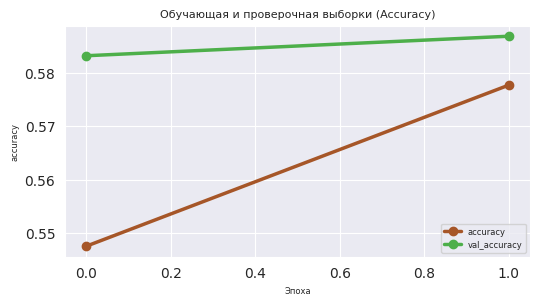

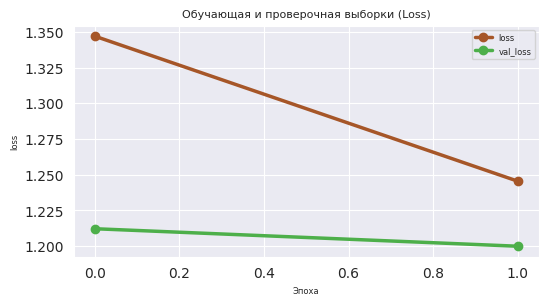

In [18]:
plot_graphs(result_training, "accuracy")
plot_graphs(result_training, "loss")

In [19]:
pred_y_int = np.array(predicted_y, dtype=int)
nl = '\n'
print(f"ОТЧЕТ О КЛАССИФИКАЦИИ: {nl} {classification_report(y_test, pred_y_int)}")

ОТЧЕТ О КЛАССИФИКАЦИИ: 
               precision    recall  f1-score   support

           0       0.51      0.40      0.45     12592
           1       0.56      0.67      0.61     16054
           2       0.61      0.69      0.65     13491
           3       0.66      0.61      0.64      8042
           4       0.62      0.39      0.48      4456
           5       0.79      0.80      0.80      6354
           6       0.50      0.58      0.53      5374
           7       0.48      0.14      0.21      2701
           8       0.51      0.60      0.55      5374
           9       0.65      0.63      0.64      5346

    accuracy                           0.59     79784
   macro avg       0.59      0.55      0.56     79784
weighted avg       0.59      0.59      0.58     79784



In [69]:
print(topic_num)
print(type(topic_num))

{'Other': 0, 'Россия': 1, 'Мир': 2, 'Экономика': 3, 'Интернет и СМИ': 4, 'Спорт': 5, 'Культура': 6, 'Из жизни': 7, 'Наука и техника': 8, 'Бывший СССР': 9}
<class 'dict'>


In [70]:
new_dict = dict(zip(topic_num.values(), topic_num.keys()))

In [71]:
print(new_dict)
print(type(new_dict))

{0: 'Other', 1: 'Россия', 2: 'Мир', 3: 'Экономика', 4: 'Интернет и СМИ', 5: 'Спорт', 6: 'Культура', 7: 'Из жизни', 8: 'Наука и техника', 9: 'Бывший СССР'}
<class 'dict'>


In [77]:
import random
n = random.randint(0, len(X_test))
print(f'Случайный топик под номером: {n}')
print(f'Текст случайного топика: {df["title"][n]}')
predicted_y = clf.predict(X_test)
print(f'Номер топика: {int(*predicted_y[n])}')
print(f'Тема топика: {new_dict[int(*predicted_y[n])]}')

Случайный топик под номером: 29611
Текст случайного топика: Английские хулиганы громят секс-шопы и автомобили
2494/2494 [==============================] - 8s 3ms/step
Номер топика: 2
Тема топика: Мир
